In [1]:
import scanpy as sc
import anndata as ad
import multigrate as mtg
from random import shuffle
from scipy import sparse
from matplotlib import pyplot as plt
import gdown

# Load the dataset

In [3]:
gdown.download(
    'https://drive.google.com/uc?id=1oaVQ7LN5Oe8L3VPoTg_y1ak3PChLwm81',
    'gayoso2020-expressions.h5ad'
)

Downloading...
From: https://drive.google.com/uc?id=1oaVQ7LN5Oe8L3VPoTg_y1ak3PChLwm81
To: /home/aomidi/theis/multigrate/example/gayoso2020-expressions.h5ad
464MB [02:33, 3.03MB/s] 


'gayoso2020-expressions.h5ad'

In [3]:
scrna = sc.read('../data/gayoso-2020/expressions.h5ad')
scrna

AnnData object with n_obs × n_vars = 30293 × 4000
    obs: 'batch_indices', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types', 'tissue', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts'
    var: 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'batch_colors', 'cell_types_colors', 'neighbors', 'pca', 'tissue_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'count'
    obsp: 'connectivities', 'distances'

In [5]:
gdown.download(
    'https://drive.google.com/uc?id=1B2AR9zY6zacnFj9coQqkLmvT6UCGa9LF',
    'gayoso2020-proteins.h5ad'
)

Downloading...
From: https://drive.google.com/uc?id=1B2AR9zY6zacnFj9coQqkLmvT6UCGa9LF
To: /home/aomidi/theis/multigrate/example/gayoso2020-proteins.h5ad
57.3MB [00:20, 2.82MB/s]


'gayoso2020-proteins.h5ad'

In [5]:
cite = sc.read('../data/gayoso-2020/protein.h5ad')
cite

AnnData object with n_obs × n_vars = 30293 × 110
    obs: 'batch_indices', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types', 'tissue', 'batch'
    var: 'n_cells'
    uns: 'batch_colors', 'cell_types_colors', 'neighbors', 'pca', 'tissue_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'count'
    obsp: 'connectivities', 'distances'

## Configure and train the model

In [9]:
model = mtg.models.MultiVAE(
    adatas=[[scrna], [cite]],
    names=[['RNA'], ['ADT']],
    pair_groups=[[0], [0]],
    condition=False,
    z_dim=20,
    h_dim=64,
    hiddens=[[], []],
    output_activations=['linear', 'linear'],
    losses=['nb', 'mse'],
    layers=[['count'], [None]],
    shared_hiddens=[],
    adver_hiddens=[],
    recon_coef=1,
    kl_coef=1e-5,
    integ_coef=1e-2, # don't have here as 1 dataset
    cycle_coef=0,
    adversarial=False,
    dropout=0.2,
)

In [10]:
model.train(
    n_iters=20000,
    batch_size=256,
    celltype_key='cell_types',
    lr=3e-4,
    val_split=0.1,
    adv_iters=0,
    kl_anneal_iters=7000,
    validate_every=2000,
    verbose=1
)

 |████████████████████| 100.0% iter=20000/20000, time=29.73(s), loss=1.9468, recon=1.9462, kl=63.3264, integ=0.0000, cycle=0.0000, val_loss=1.9040, val_recon=1.9034, val_kl=60.2188, val_integ=0.0000, val_cycle=0.0000

## Plot training history

In [11]:
model.history

,iteration,train_loss,train_recon,train_kl,train_integ,train_cycle,val_loss,val_recon,val_kl,val_integ,val_cycle
0,2000,2.043198,2.043134,33.174453,0.0,0.0,1.940512,1.940396,40.783483,0,0
1,4000,1.792344,1.792062,60.613822,0.0,0.0,1.929080,1.928694,67.476440,0,0
2,6000,2.021821,2.021260,75.443639,0.0,0.0,1.926649,1.926040,71.002797,0,0
3,8000,1.979821,1.979098,74.044849,0.0,0.0,1.913289,1.912647,64.217560,0,0
4,10000,1.879814,1.879118,69.582454,0.0,0.0,1.915279,1.914591,68.786474,0,0
5,12000,2.002852,2.002167,68.543933,0.0,0.0,1.907540,1.906928,61.107035,0,0
6,14000,1.777840,1.777167,67.337726,0.0,0.0,1.905983,1.905363,62.025965,0,0
7,16000,1.994898,1.994241,65.767268,0.0,0.0,1.907810,1.907160,64.980052,0,0
8,18000,2.072610,2.071970,63.914874,0.0,0.0,1.899814,1.899206,60.855036,0,0
9,19999,1.946805,1.946172,63.326389,0.0,0.0,1.904036,1.903433,60.218836,0,0


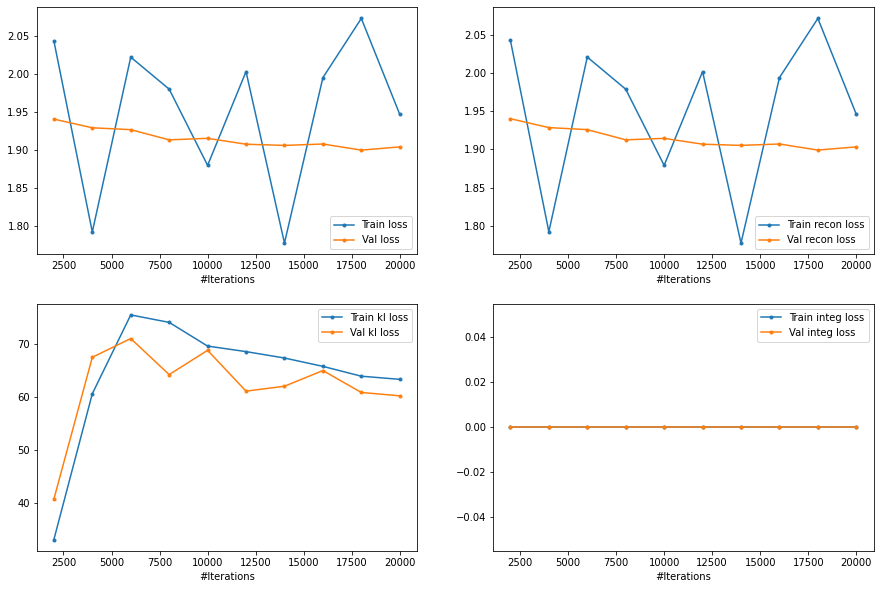

In [12]:
plt.figure(figsize=(15, 10));
plt.subplot(221);
plt.plot(model.history['iteration'], model.history['train_loss'], '.-', label='Train loss');
plt.plot(model.history['iteration'], model.history['val_loss'], '.-', label='Val loss');
plt.xlabel('#Iterations');
plt.legend();

plt.subplot(222);
plt.plot(model.history['iteration'], model.history['train_recon'], '.-', label='Train recon loss');
plt.plot(model.history['iteration'], model.history['val_recon'], '.-', label='Val recon loss');
plt.xlabel('#Iterations');
plt.legend();

plt.subplot(223);
plt.plot(model.history['iteration'], model.history['train_kl'], '.-', label='Train kl loss');
plt.plot(model.history['iteration'], model.history['val_kl'], '.-', label='Val kl loss');
plt.xlabel('#Iterations');
plt.legend();

plt.subplot(224);
plt.plot(model.history['iteration'], model.history['train_integ'], '.-', label='Train integ loss');
plt.plot(model.history['iteration'], model.history['val_integ'], '.-', label='Val integ loss');
plt.xlabel('#Iterations');
plt.legend();

## Recover and visualize the latent space

In [14]:
z = model.predict(
    adatas=[[scrna], [cite]],
    names=[['RNA'], ['ADT']],
    pair_groups=[[0], [0]],
    batch_size=256,
    celltype_key='cell_types',
)
z

AnnData object with n_obs × n_vars = 30293 × 20
    obs: 'modality', 'barcode', 'cell_types', 'batch'

In [15]:
sc.pp.neighbors(z)
sc.tl.umap(z)

/home/icb/anastasia.litinetskaya/miniconda3/envs/multigrate/lib/python3.7/site-packages/scanpy/neighbors/__init__.py:121: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp[distances], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['distances'] = neighbors.distances
/home/icb/anastasia.litinetskaya/miniconda3/envs/multigrate/lib/python3.7/site-packages/scanpy/neighbors/__init__.py:122: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'] = neighbors.connectivities
/home/icb/anastasia.litinetskaya/miniconda3/envs/multigrate/lib/python3.7/site-packages/scanpy/tools/_umap.py:147: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  ada

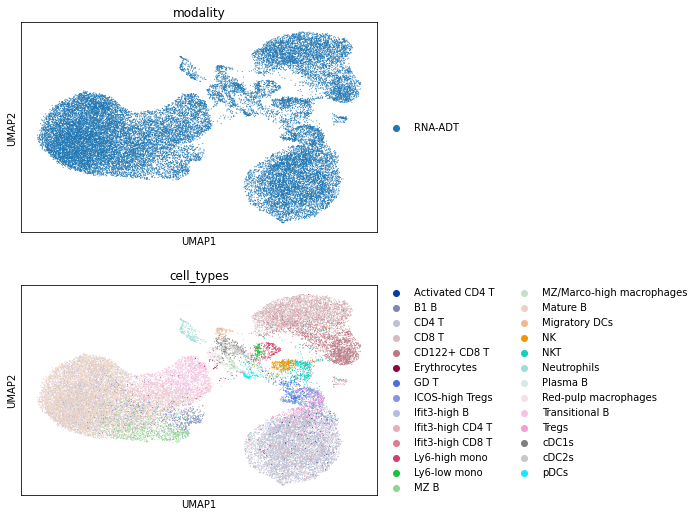

In [17]:
sc.pl.umap(z, color=['modality', 'cell_types'], ncols=1)

In [18]:
z.obs_names = z.obs.barcode
z.obs

,modality,barcode,cell_types,batch
barcode,,,,
AAACCCAAGGGTAATT-1,RNA-ADT,AAACCCAAGGGTAATT-1,NKT,0
AAACCCAAGGTAAACT-1,RNA-ADT,AAACCCAAGGTAAACT-1,CD122+ CD8 T,0
AAACCCACACTAGGTT-1,RNA-ADT,AAACCCACACTAGGTT-1,Transitional B,0
AAACCCACAGATACCT-1,RNA-ADT,AAACCCACAGATACCT-1,Mature B,0
AAACCCACAGGAATAT-1,RNA-ADT,AAACCCACAGGAATAT-1,CD4 T,0
...,...,...,...,...
TTTGTTGGTGGGCTCT-2,RNA-ADT,TTTGTTGGTGGGCTCT-2,Mature B,118
TTTGTTGTCAAATAGG-2,RNA-ADT,TTTGTTGTCAAATAGG-2,CD8 T,118
TTTGTTGTCACGAGGA-2,RNA-ADT,TTTGTTGTCACGAGGA-2,CD4 T,118


In [19]:
z.obs_names == scrna.obs_names

array([ True,  True,  True, ...,  True,  True,  True])

In [20]:
z.obs = scrna.obs

In [21]:
z.obs

,batch_indices,n_genes,percent_mito,leiden_subclusters,cell_types,tissue,batch,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts
index,,,,,,,,,,,
AAACCCAAGGGTAATT-1,0,3126,0.062138,"12,0",NKT,Spleen,SLN111-D1,3126,8.047829,9836.0,9.193906
AAACCCAAGGTAAACT-1,0,2254,0.057545,6,CD122+ CD8 T,Spleen,SLN111-D1,2254,7.720905,7453.0,8.916506
AAACCCACACTAGGTT-1,0,1363,0.058373,3,Transitional B,Spleen,SLN111-D1,1363,7.218177,3131.0,8.049427
AAACCCACAGATACCT-1,0,1566,0.065386,4,Mature B,Lymph_Node,SLN111-D1,1566,7.356918,4266.0,8.358666
AAACCCACAGGAATAT-1,0,1893,0.059644,0,CD4 T,Lymph_Node,SLN111-D1,1893,7.546446,5665.0,8.642239
...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGGTGGGCTCT-2,1,783,0.106437,7,Mature B,Spleen,SLN208-D2,783,6.664409,1567.0,7.357556
TTTGTTGTCAAATAGG-2,1,978,0.050457,2,CD8 T,Lymph_Node,SLN208-D2,978,6.886532,2298.0,7.740230
TTTGTTGTCACGAGGA-2,1,747,0.070362,0,CD4 T,Spleen,SLN208-D2,747,6.617403,1407.0,7.249926


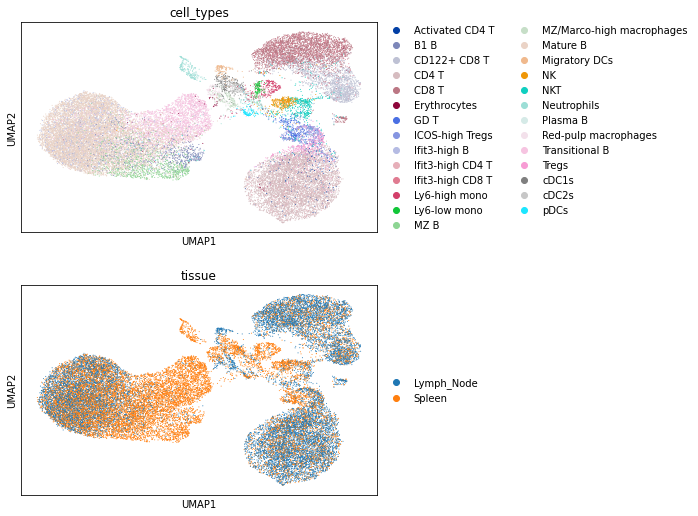

In [22]:
sc.pl.umap(z, color=['cell_types', 'tissue'], ncols=1)

In [23]:
z.write('../data/integrated/multigrate/gayoso-multigrate.h5ad')